In [1]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme()

import sklearn
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

import tensorflow as tf
from tensorflow import keras
from keras import models, layers, optimizers, losses, preprocessing, regularizers
import tensorflow_hub as hub
import tensorflow_text

import xgboost as xgb
import catboost as cb

# Check if GPU is available

In [2]:
tf.config.list_physical_devices(device_type='GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Load Data

In [3]:
df_train = pd.read_csv('../../Data/contradictory-my-dear-watson/train.csv')
df_test  = pd.read_csv('../../Data/contradictory-my-dear-watson/test.csv')

df_all = pd.concat([df_train, df_test])

print(f'df_train.shape = {df_train.shape}')
print(f'df_test.shape  = {df_test.shape}')
print(f'df_all.shape   = {df_all.shape}')

df_train.shape = (12120, 6)
df_test.shape  = (5195, 5)
df_all.shape   = (17315, 6)


In [4]:
df_train.head(2)

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2


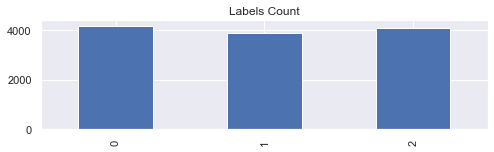

In [5]:
_ = df_train['label'].value_counts().sort_index().plot.bar(figsize=(8,2), title='Labels Count')

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12120 entries, 0 to 12119
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          12120 non-null  object
 1   premise     12120 non-null  object
 2   hypothesis  12120 non-null  object
 3   lang_abv    12120 non-null  object
 4   language    12120 non-null  object
 5   label       12120 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 568.2+ KB


# Train-Test Split

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    df_train.text.values, df_train.target.values,
    stratify=df_train.target.values,
    random_state=42,
    test_size=0.1,
    shuffle=True
)

print(f'X_train.shape = {X_train.shape} | y_train.shape = {y_train.shape}')
print(f'X_val.shape   = {X_val.shape}  | y_val.shape   = {y_val.shape}')

# Building Basic Models

### Logistic Regression on TF-IDF

In [ ]:
tfv = TfidfVectorizer(
    min_df=3,
    max_features=None,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    ngram_range=(1,3),
    use_idf=1,
    smooth_idf=1,
    sublinear_tf=1,
    stop_words='english'
)

tfv.fit(list(X_train) + list(X_val))

X_train_tfv = tfv.transform(X_train)
X_val_tfv   = tfv.transform(X_val)

print(f'X_train_tfv.shape = {X_train_tfv.shape} | y_train.shape = {y_train.shape}')
print(f'X_val_tfv.shape   = {X_val_tfv.shape}  | y_val.shape   = {y_val.shape}')

In [ ]:
clf = LogisticRegression(C=1.0)
clf.fit(X_train_tfv, y_train)

predictions = clf.predict(X_val_tfv)

print(f'F1 Score  = {np.round(metrics.f1_score(y_true=y_val, y_pred=predictions),5)}')
print(f'Precision = {np.round(metrics.precision_score(y_true=y_val, y_pred=predictions),5)}')
print(f'Recall    = {np.round(metrics.recall_score(y_true=y_val, y_pred=predictions),5)}')

### Logistic Regression on CountVectorizer

In [ ]:
ctv = CountVectorizer(
    analyzer='word',
    token_pattern='\w{1,}',
    ngram_range=(1,3),
    stop_words='english',
)

ctv.fit(list(X_train) + list(X_val))

X_train_ctv = ctv.transform(X_train)
X_val_ctv   = ctv.transform(X_val)

print(f'X_train_ctv.shape = {X_train_ctv.shape} | y_train.shape = {y_train.shape}')
print(f'X_val_ctv.shape   = {X_val_ctv.shape}  | y_val.shape   = {y_val.shape}')

In [ ]:
clf = LogisticRegression(C=1.0)
clf.fit(X_train_ctv, y_train)

predictions = clf.predict(X_val_ctv)

print(f'F1 Score  = {np.round(metrics.f1_score(y_true=y_val, y_pred=predictions),5)}')
print(f'Precision = {np.round(metrics.precision_score(y_true=y_val, y_pred=predictions),5)}')
print(f'Recall    = {np.round(metrics.recall_score(y_true=y_val, y_pred=predictions),5)}')

### Naive Bayes on TF-IDF

In [ ]:
clf = MultinomialNB()
clf.fit(X_train_tfv, y_train)

predictions = clf.predict(X_val_tfv)

print(f'F1 Score  = {np.round(metrics.f1_score(y_true=y_val, y_pred=predictions),5)}')
print(f'Precision = {np.round(metrics.precision_score(y_true=y_val, y_pred=predictions),5)}')
print(f'Recall    = {np.round(metrics.recall_score(y_true=y_val, y_pred=predictions),5)}')

### XGBoost on TF-IDF

In [ ]:
clf = xgb.XGBClassifier(
    max_depth=7, 
    n_estimators=200, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    nthread=10, 
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='logloss',
)

clf.fit(X_train_tfv, y_train)

predictions = clf.predict(X_val_tfv)

print(f'F1 Score  = {np.round(metrics.f1_score(y_true=y_val, y_pred=predictions),5)}')
print(f'Precision = {np.round(metrics.precision_score(y_true=y_val, y_pred=predictions),5)}')
print(f'Recall    = {np.round(metrics.recall_score(y_true=y_val, y_pred=predictions),5)}')

### XGBoost on CountVectorizer

In [ ]:
clf = xgb.XGBClassifier(
    max_depth=7, 
    n_estimators=200, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    nthread=10, 
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='logloss',
)

clf.fit(X_train_ctv, y_train)

predictions = clf.predict(X_val_ctv)

print(f'F1 Score  = {np.round(metrics.f1_score(y_true=y_val, y_pred=predictions),5)}')
print(f'Precision = {np.round(metrics.precision_score(y_true=y_val, y_pred=predictions),5)}')
print(f'Recall    = {np.round(metrics.recall_score(y_true=y_val, y_pred=predictions),5)}')

# Deep Learning

In [ ]:
tf.random.set_seed(42)

In [ ]:
TFHUB_CACHE_DIR = os.path.join(os.curdir, "my_tfhub_cache")
os.environ["TFHUB_CACHE_DIR"] = TFHUB_CACHE_DIR

### Using nnlm-en-dim50/1 embedding

In [ ]:
model = keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1",
                   dtype=tf.string, input_shape=[], output_shape=[50]),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])

model.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy"])

In [ ]:
history = model.fit(
    X_train, y_train, 
    validation_data=(X_val, y_val),
    epochs=5,
    verbose=0
)

In [ ]:
model.evaluate(X_val, y_val)

In [ ]:
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()

In [ ]:
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()

In [ ]:
predictions = model.predict(X_val)

predictions = np.round(predictions)

print(f'F1 Score  = {np.round(metrics.f1_score(y_true=y_val, y_pred=predictions),5)}')
print(f'Precision = {np.round(metrics.precision_score(y_true=y_val, y_pred=predictions),5)}')
print(f'Recall    = {np.round(metrics.recall_score(y_true=y_val, y_pred=predictions),5)}')

### Using universal-sentence-encoder-multilingual embedding

In [ ]:
model = keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-multilingual/3",
                   dtype=tf.string, input_shape=[], output_shape=[]),    
    layers.Dense(128, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

model.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy"])

In [ ]:
history = model.fit(
    X_train, y_train, 
    validation_data=(X_val, y_val),
    epochs=2,
    verbose=1
)

In [ ]:
model.evaluate(X_val, y_val)

In [ ]:
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()

In [ ]:
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()

In [ ]:
predictions = model.predict(X_val)

predictions = np.round(predictions)

print(f'F1 Score  = {np.round(metrics.f1_score(y_true=y_val, y_pred=predictions),5)}')
print(f'Precision = {np.round(metrics.precision_score(y_true=y_val, y_pred=predictions),5)}')
print(f'Recall    = {np.round(metrics.recall_score(y_true=y_val, y_pred=predictions),5)}')

In [ ]:
predictions = model.predict(df_test.text.values)
predictions = np.round(predictions).astype(int)

submission = pd.DataFrame({'id': df_test['id'], 'target': predictions.reshape(-1)})
submission.to_csv('submission.csv', index=False)

#### Leaderboard Score

<img src="score_univ_sen_encoder.png">

### Using universal-sentence-encoder-multilingual embedding + LSTM

In [ ]:
model = keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-multilingual/3",
                   dtype=tf.string, input_shape=[], output_shape=[]),    
    layers.Reshape((-1,512)),
    layers.LSTM(4),
    layers.Dense(4, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

model.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy"])

In [ ]:
history = model.fit(
    X_train, y_train, 
    validation_data=(X_val, y_val),
    epochs=8,
    verbose=1
)

In [ ]:
model.evaluate(X_val, y_val)

In [ ]:
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()

In [ ]:
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()

In [ ]:
predictions = model.predict(X_val)

predictions = np.round(predictions)

print(f'F1 Score  = {np.round(metrics.f1_score(y_true=y_val, y_pred=predictions),5)}')
print(f'Precision = {np.round(metrics.precision_score(y_true=y_val, y_pred=predictions),5)}')
print(f'Recall    = {np.round(metrics.recall_score(y_true=y_val, y_pred=predictions),5)}')

In [ ]:
predictions = model.predict(df_test.text.values)
predictions = np.round(predictions).astype(int)

submission = pd.DataFrame({'id': df_test['id'], 'target': predictions.reshape(-1)})
submission.to_csv('submission.csv', index=False)

## Using pre-trained BERT

In [ ]:
early_stopping_monitor = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

In [ ]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)

preprocessor = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")

encoder_inputs = preprocessor(text_input)

encoder = hub.KerasLayer(    
    "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4",
    trainable=False
)

outputs = encoder(encoder_inputs)

pooled_output = outputs["pooled_output"]      # [batch_size, 768].
sequence_output = outputs["sequence_output"]  # [batch_size, seq_length, 768].

embedding_model = tf.keras.Model(text_input, pooled_output)

model = keras.Sequential([
    embedding_model,
    layers.Dense(1024, activation='relu', activity_regularizer=regularizers.l2(1e-5)),
    layers.Dense(1024, activation='relu', activity_regularizer=regularizers.l2(1e-5)),
    layers.Dense(1024, activation='relu', activity_regularizer=regularizers.l2(1e-5)),
#     layers.Dense(64, activation="relu"),
#     layers.Dense(32, activation="relu"),
#     layers.Dense(8, activation="relu"),
    layers.Dense(1, activation='sigmoid')
])

model.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy"])

In [ ]:
history = model.fit(
    X_train, y_train, 
    validation_data=(X_val, y_val),
    epochs=25,
    batch_size=16,
    verbose=1,
    callbacks=[early_stopping_monitor]
)

In [ ]:
model.evaluate(X_val, y_val)

In [ ]:
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()

In [ ]:
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()

In [ ]:
predictions = model.predict(X_val)

predictions = np.round(predictions)

print(f'F1 Score  = {np.round(metrics.f1_score(y_true=y_val, y_pred=predictions),5)}')
print(f'Precision = {np.round(metrics.precision_score(y_true=y_val, y_pred=predictions),5)}')
print(f'Recall    = {np.round(metrics.recall_score(y_true=y_val, y_pred=predictions),5)}')

In [ ]:
predictions = model.predict(df_test.text.values)
predictions = np.round(predictions).astype(int)

submission = pd.DataFrame({'id': df_test['id'], 'target': predictions.reshape(-1)})
submission.to_csv('submission.csv', index=False)

# Bidirectional LSTM with trained Embedding and Masking

In [ ]:
max_tokens = 20000
max_length = 600

text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)

text_vectorization.adapt(df_train.text.values)

In [ ]:
text_vectorization("This layer transforms sentences to sequences of integer numbers").shape

In [ ]:
model = models.Sequential(
    [
        text_vectorization,
        layers.Embedding(input_dim=max_tokens, output_dim=512, mask_zero=True),
#         layers.Bidirectional(layers.LSTM(4, return_sequences=True)),
#         layers.Bidirectional(layers.LSTM(16, return_sequences=True)),
        layers.Bidirectional(layers.LSTM(4)),        
#         layers.Dropout(0.5),
        layers.Dense(4, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ]
)

model.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint("bidirectional_lstm.tf", save_best_only=True, save_format='tf')
]

history = model.fit(
    X_train, y_train, 
#     df_train.text.values, df_train.target.values,
    validation_data=(X_val, y_val),
    epochs=5,
    callbacks=callbacks
)

In [ ]:
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()

In [ ]:
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()

In [ ]:
model = models.load_model("bidirectional_lstm.tf")

model.evaluate(X_val, y_val)

In [ ]:
predictions = model.predict(X_val)

predictions = np.round(predictions)

print(f'F1 Score  = {np.round(metrics.f1_score(y_true=y_val, y_pred=predictions),5)}')
print(f'Precision = {np.round(metrics.precision_score(y_true=y_val, y_pred=predictions),5)}')
print(f'Recall    = {np.round(metrics.recall_score(y_true=y_val, y_pred=predictions),5)}')

In [ ]:
predictions = model.predict(df_test.text.values)
predictions = np.round(predictions).astype(int)

submission = pd.DataFrame({'id': df_test['id'], 'target': predictions.reshape(-1)})
submission.to_csv('submission.csv', index=False)